In [1]:
# Dependencies
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the full dataset and conduct data cleaning
# train_data=pd.read_csv('Resources/train.csv')

In [3]:
#descriptives of train_data to spot any thing that requires cleaning
#train_data.describe()

In [4]:
#drop the rows that fares are negative or equal to 0
#train_cleaned = train_data.drop(train_data[train_data['fare_amount']<=0].index)

#making sure all pick-up and drop-off are based inside New York City.
#New York City latitude and longitude range is: North Latitude: 40.917577 South Latitude: 40.477399 East Longitude: -73.700272 West Longitude: -74.259090
#Source: https://www.mapdevelopers.com/geocode_bounding_box.php
#Data out of the range will be cleaned out
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['pickup_longitude']>-73.700272].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['pickup_longitude']<-74.259090].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['dropoff_longitude']>-73.700272].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['dropoff_longitude']<-74.259090].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['pickup_latitude']>40.917577].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['pickup_latitude']<40.477399].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['dropoff_latitude']>40.917577].index)
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['dropoff_latitude']<40.477399].index)

In [5]:
#cleaned out the fare > 500
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['fare_amount']>500].index)
#train_cleaned.describe()

In [6]:
#cleaend out passenger_count > 9
#train_cleaned = train_cleaned.drop(train_cleaned[train_cleaned['passenger_count']>9].index)
#final clean data descriptives
#train_cleaned.describe()

In [7]:
#sample 25% of the training data
#sample_data = train_data.sample(frac=.25)
#sample_data.tail()
#sample_data.to_csv("Resources/sample.csv")
#sample_data.to_csv('Resources/sample_data_cleaned.csv', sep='\t')
#save the cleaned train data to csv
#train_cleaned.to_csv('train_data_cleaned.csv', sep='\t')

In [17]:
#Reading the cleaned 25% sample data from csv to use forward
data_df = pd.read_csv('Resources/sample_data_cleaned.csv')

# ------ TEMPORARY ----------
data_df = data_df.sample(frac=.25)

In [18]:
#calculate the distance between pick-up and drop-off spot
def distance(row):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = row['pickup_latitude'], row['pickup_longitude']
    lat2, lon2 = row['dropoff_latitude'], row['dropoff_longitude']
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [19]:
data_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
13556227,28172164,2011-12-20 14:42:44.0000003,8.9,2011-12-20 14:42:44 UTC,-73.869476,40.771234,-73.869476,40.771234,1
2148705,49169775,2014-05-15 16:06:13.0000001,6.5,2014-05-15 16:06:13 UTC,-73.981536,40.749734,-73.975218,40.758063,1
5350631,33255590,2011-06-17 17:47:27.0000002,8.1,2011-06-17 17:47:27 UTC,-73.987007,40.733341,-73.990838,40.748916,1
1281642,42728906,2011-12-11 14:45:57.0000005,7.3,2011-12-11 14:45:57 UTC,-73.991044,40.764835,-73.991599,40.749892,1
2674081,43537484,2014-07-23 06:06:56.0000001,4.5,2014-07-23 06:06:56 UTC,-73.994140,40.751712,-74.004627,40.752367,1


In [20]:
data_df['new_time'] = (data_df['pickup_datetime']).apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z"))    
data_df = data_df.drop(['Unnamed: 0','key','pickup_datetime'], axis=1)
time_range = (data_df['new_time'] > "2013-01-01") & (data_df['new_time'] < "2016-12-31")
ranged_data = data_df.loc[time_range]

In [21]:
ranged_data['distance'] = data_df.apply(distance, axis=1)

In [22]:
ranged_data['year'] = data_df['new_time'].apply(lambda x: x.year)
ranged_data['hour_of_day'] = data_df['new_time'].apply(lambda x: x.hour)
ranged_data['day'] = data_df['new_time'].apply(lambda x: calendar.day_name[x.weekday()])
ranged_data['date'] = data_df['new_time'].apply(lambda x: x.date())

#plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])

ranged_data = ranged_data[ranged_data['distance'] < 100]


In [23]:
dummied_data = ranged_data

for column in dummied_data.columns:
 if dummied_data[column].dtype==object:
  dummyCols=pd.get_dummies(dummied_data[column])
  dummied_data=dummied_data.join(dummyCols)
  del dummied_data[column]

fares = dummied_data['fare_amount']
dummied_data.drop(['fare_amount','pickup_longitude', 'pickup_latitude','dropoff_longitude','new_time'], axis=1,inplace=True)


model_1=LinearRegression()
model_1.fit(dummied_data,fares)
coefficients=pd.DataFrame({'name':list(dummied_data),'value':model_1.coef_})
print("Mean squared error:",np.mean((model_1.predict(dummied_data) - fares) ** 2))
print("R²:",model_1.score(dummied_data, fares))

Mean squared error: 37.46938530496609
R²: 0.7133125534824478


In [52]:
ranged_data = ranged_data.drop(ranged_data[ranged_data['passenger_count'] == 0].index)
ranged_data.sort_values(by='passenger_count')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance,year,hour_of_day,day,date
2319800,15.50,-73.989960,40.733950,-73.987570,40.760190,1,2014-12-20 16:11:00,2.924693,2014,16,Saturday,2014-12-20
3455508,8.50,-73.922977,40.755395,-73.945044,40.750273,1,2014-12-07 04:32:51,1.944085,2014,4,Sunday,2014-12-07
4439642,9.00,-73.978367,40.751942,-73.972165,40.760982,1,2014-07-02 20:31:00,1.132838,2014,20,Wednesday,2014-07-02
10442803,18.50,-74.016815,40.709198,-73.979134,40.759010,1,2015-03-03 06:48:39,6.384317,2015,6,Tuesday,2015-03-03
9085885,18.50,-73.952737,40.772467,-74.000453,40.758475,1,2014-02-04 08:20:00,4.309207,2014,8,Tuesday,2014-02-04
4131704,4.50,-73.897060,40.846897,-73.905110,40.853747,1,2013-08-06 22:04:55,1.019123,2013,22,Tuesday,2013-08-06
1235641,3.50,-73.977327,40.755702,-73.974217,40.759712,1,2013-02-12 08:21:00,0.517142,2013,8,Tuesday,2013-02-12
3673491,4.50,-73.954139,40.770229,-73.949345,40.781031,1,2013-09-21 19:41:04,1.267148,2013,19,Saturday,2013-09-21
9816000,16.50,-73.990030,40.756300,-73.999510,40.713870,1,2014-09-24 20:26:00,4.785137,2014,20,Wednesday,2014-09-24
2814283,7.50,-73.999920,40.761380,-73.986452,40.767112,1,2013-03-22 18:40:31,1.301076,2013,18,Friday,2013-03-22


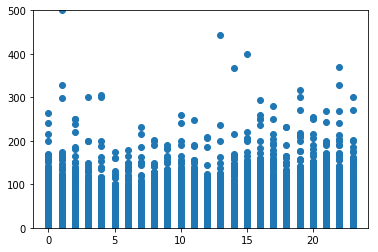

In [53]:
plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 24 artists>

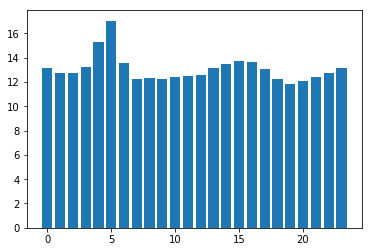

In [54]:
by_distance=ranged_data.groupby(by='hour_of_day')
#x = x.drop(x['day'] == 'Sunday')
x = by_distance.agg('mean')['fare_amount']
plt.bar(x.index,x)

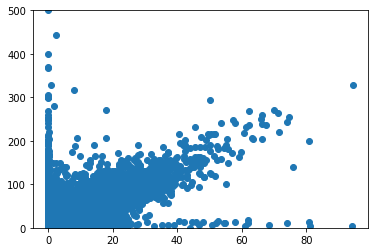

In [55]:
plt.scatter(ranged_data['distance'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

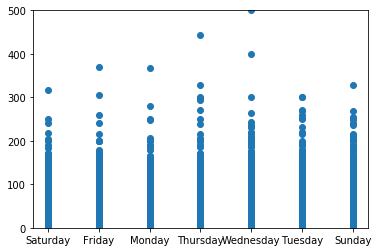

In [56]:
plt.scatter(ranged_data['day'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 7 artists>

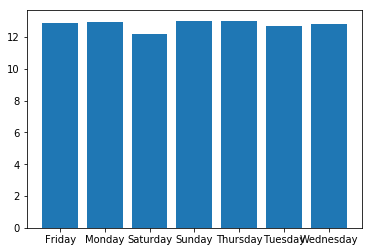

In [57]:
by_distance=ranged_data.groupby(by='day')
#x = x.drop(x['day'] == 'Sunday')
x = by_distance.agg('mean')['fare_amount']
plt.bar(x.index,x)

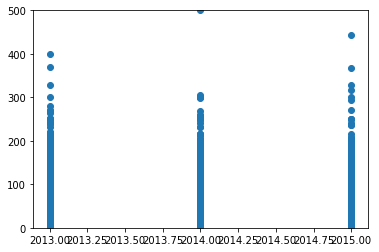

In [58]:
plt.scatter(ranged_data['year'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 3 artists>

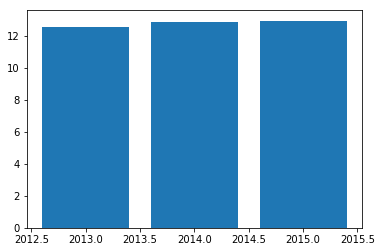

In [59]:
by_distance=ranged_data.groupby(by='year')
x = by_distance.agg('mean')['fare_amount']
plt.bar(x.index,x)

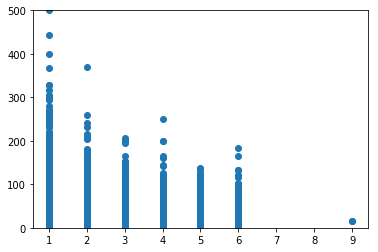

In [60]:
plt.scatter(ranged_data['passenger_count'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 7 artists>

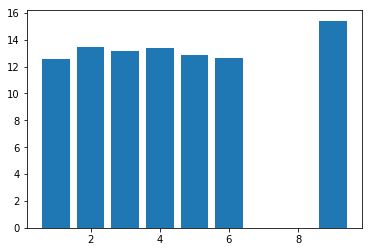

In [61]:
by_distance=ranged_data.groupby(by='passenger_count')
x = by_distance.agg('mean')['fare_amount']
plt.bar(x.index,x)